# H5PY examples

Let's stack some images into an HDF5 object. Applications and motivation:
- Principal documentation:  
  https://docs.h5py.org/en/stable/high/dataset.html  


- Especially for lots of small images, consolidate many, many image files into a single container.
- Expect significantly ML training performance, by improving IO performance
- Much more efficient storage (filesystems are limited by inodes -- or discrete numbers of file-like objects)
- Simpler organization of data

## Images and HDF5:
Some docs:
  https://matplotlib.org/stable/tutorials/images.html

Overview:
- You have a bunch of image (`.png`) files...
- Print some thumbnails of those images
- Show that an image file is just an array of numbers
- Create an HDF5 object
- Add the images to the HDF5 object as numerical arrays
- Separate those images into two groups
- Extract and plot those images from the HDF5 object


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import h5py
#import hdf5plugin
import matplotlib as mpl
import pylab as plt
import os

import imageio.v3 as iio

Define a source directory and create list of image files. This is a sloppy way to sort and select only the files we want, but it does the trick. Ideally you should select your files in code, allowing auxiliary files, meta-data, etc. in the directory.

In [3]:
img_path = './images_h5'
image_names = os.listdir(img_path)
image_names = [os.path.join(img_path, f) for f in image_names if f.endswith('.png') and 'Small' in f]
image_names = [os.path.abspath(f) for f in image_names]
print('** Image files: ', image_names)

** Image files:  ['/Users/myoder96/Codes/src_python_demos/images_h5/IMG_6989_Small.png', '/Users/myoder96/Codes/src_python_demos/images_h5/IMG_6974_Small.png', '/Users/myoder96/Codes/src_python_demos/images_h5/IMG_6947_Small.png', '/Users/myoder96/Codes/src_python_demos/images_h5/IMG_6968_Small.png', '/Users/myoder96/Codes/src_python_demos/images_h5/IMG_6970_Small.png']


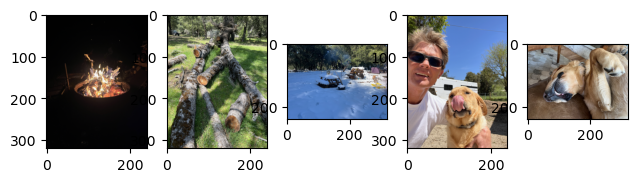

In [4]:
# let's do some thumbnails, for reference
w=5
h=1.5*w
#
N = len(image_names)
fg = plt.figure(figsize=(h, N*w))
#
axes = [fg.add_subplot(1,N,k+1) for k in range(N)]
for k, (ax,im) in enumerate(zip(axes,image_names)):
    ax.imshow(iio.imread(im))
#

### First, let's just look at .png image layers:

- Load some image names into a list
- use imshow() to look at the image layers
- Note that the depth of images may vary. Some `.png` images are `(N,M,3)`, where others are `(N,M,4)`.
- If we are smart, we will dynamically determine the depth. For this demo, we are just going to use the first three levels and the aggregate.

In [5]:
img_array = iio.imread(image_names[0])
print(f'image array shape: {img_array.shape}')

image array shape: (320, 240, 4)


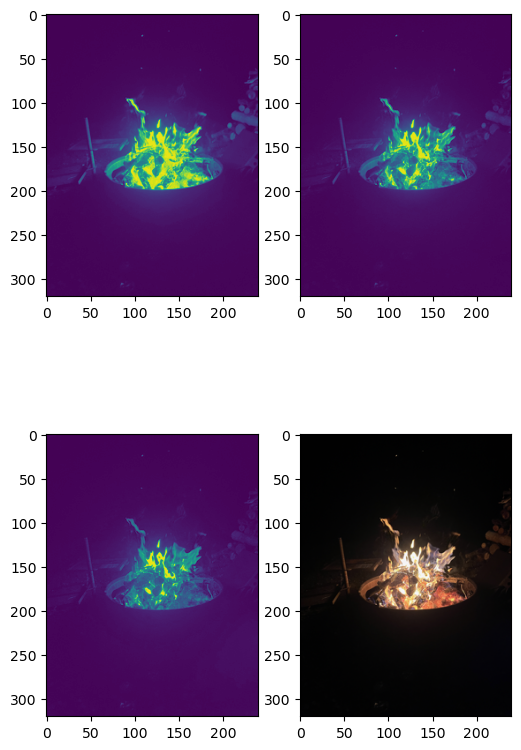

In [6]:
fg = plt.figure(figsize=(6,10))
axes = [fg.add_subplot(2,2,k+1) for k in range(4)]
#
for k, ax in enumerate(axes[0:3]):
    ax.imshow(img_array[:,:,k])
axes[3].imshow(img_array)



## Create an HDF5 object
### Add images as arrays...
- Quick Start: https://docs.h5py.org/en/stable/quick.html
- We have two clases of images:
  - Photos from "The Yo"
  - Photos of Beru
- Separate those photos into two groups:
  - TheYo
  - Beru
- More practically, for ML applications you might have:
  - training_imaes
  - validation_images
  - demo_images




In [7]:
h5_images = 'yo_images.h5'
ks_yo = [0,1,2]
ks_beru = [3,4]
#
h5_images_fp = os.path.join(img_path, h5_images)
#
with h5py.File(h5_images_fp, 'w') as h5_obj:
    #
    # create group(s). Note that we do not necessarily need to add the groups in advance. We can
    #. create them by providing a full(er) path in create_dataset()
    h5_obj.create_group('TheYo')
    #h5_obj.create_group('Beru')
    #
    # add Yo images:
    for k in ks_yo:
        h5_obj.create_dataset(f'TheYo/im_{k}', data=iio.imread(image_names[k]))
    #
    # add Beru images:
    for k in ks_beru:
        h5_obj.create_dataset(f'Beru/im_{k}', data=iio.imread(image_names[k]))
    #

## Reading HDF5 data
- basically a nested dict-like, array (JSON-like) structuer
  - {'image_set': {img_name:img_data, ...}, ...}

ky: Beru
  ds: im_3[(320, 240, 4)]
  ds: im_4[(240, 320, 4)]
ky: TheYo
  ds: im_0[(320, 240, 4)]
  ds: im_1[(320, 240, 4)]
  ds: im_2[(240, 320, 4)]
ky: Beru
ky: TheYo
** subplot dimensions: 2, 3
** image index: 1
** image index: 2
** image index: 4
** image index: 5
** image index: 6


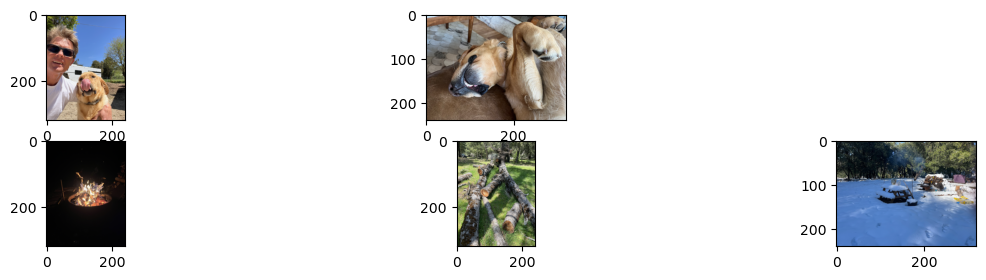

In [8]:
with h5py.File(h5_images_fp, 'r') as fout:
    for ky in fout:
        print(f'ky: {ky}')
        for ds,vl in fout[ky].items():
            print(f'  ds: {ds}[{vl.shape}]')
#
# and show some thumbnails in a semi-dynamic way:
with h5py.File(h5_images_fp, 'r') as fout:
    n_groups = len(fout.keys())
    #
    n_cols = 0
    for ky in fout:
        print(f'ky: {ky}')
        n_cols = max(n_cols, len(fout[ky].keys()))
    #
    fg = plt.figure(figsize=(h*n_groups, n_cols))
    #
    #
    print(f'** subplot dimensions: {n_groups}, {n_cols}')
    
    # introduce some more efficient syntax:
    for k_rw, (ky,grp) in enumerate(fout.items()):
        
        for k_col, (nm,data) in enumerate(grp.items()):
            kc = k_col+1
            #
            k_img = k_rw*(n_cols) + k_col+1
            print(f'** image index: {k_img}')
            #
            ax = fg.add_subplot(n_groups, n_cols, k_img)
            ax.imshow(data)
        #
    #
        

## Compression
The astute reader will likely be disappointed to observe that the HDF5 object, created above, is some 2x as large as the collection of PNG files. This is (presumably...) because the HDF5 data are stored as a raw array and forego compression available to the image-type format.

Fortunately, `h5py`, as well as other HDF5 interfaces, support a variety of compression options. Again, the primary `h5py` documentation is quite helpful: https://docs.h5py.org/en/stable/high/dataset.html

Three popular lossless compression algorithms, supported by `h5py`, include:
- `compression="gzip" compression_opts={0,9}`  # variable compression; supported by all `h5py` builds
- `compresion="lzf"`                           # fast, low to moderate compression; all `h5py` builds
- `compression="szip"`                         # available with some `h5py` builds


### GZIP:

In [12]:
# gzip example:

h5_images_gz = 'yo_images_gz9.h5'
#ks_yo = [0,1,2]
#ks_beru = [3,4]
#
h5_images_gz_fp = os.path.join(img_path, h5_images_gz)
#
with h5py.File(h5_images_gz_fp, 'w') as h5_obj:
    #
    # create group(s). Note that we do not necessarily need to add the groups in advance. We can
    #. create them by providing a full(er) path in create_dataset()
    h5_obj.create_group('TheYo')
    #h5_obj.create_group('Beru')
    #
    # add Yo images:
    for k in ks_yo:
        h5_obj.create_dataset(f'TheYo/im_{k}', data=iio.imread(image_names[k]),
                              compression="gzip", compression_opts=9)
    #
    # add Beru images:
    for k in ks_beru:
        h5_obj.create_dataset(f'Beru/im_{k}', data=iio.imread(image_names[k]),
                              compression="gzip", compression_opts=9)
    #

### LZF:

In [13]:
h5_images = 'yo_images_lzf.h5'
#ks_yo = [0,1,2]
#ks_beru = [3,4]
#
h5_images_fp = os.path.join(img_path, h5_images)
#
with h5py.File(h5_images_fp, 'w') as h5_obj:
    #
    # create group(s). Note that we do not necessarily need to add the groups in advance. We can
    #. create them by providing a full(er) path in create_dataset()
    h5_obj.create_group('TheYo')
    #h5_obj.create_group('Beru')
    #
    # add Yo images:
    for k in ks_yo:
        h5_obj.create_dataset(f'TheYo/im_{k}', data=iio.imread(image_names[k]), compression="lzf")
    #
    # add Beru images:
    for k in ks_beru:
        h5_obj.create_dataset(f'Beru/im_{k}', data=iio.imread(image_names[k]), compression="lzf")
    #

## HDF5 Plugin:
Additional compression filter are available from HDF5 Plugin -- amongst other sources. Additional filters are made aviablie by importing the `hdf5plugin` Python module, eg:
    import hdf5plugin

It may be necessary to install the `hdf5plugin` package:
https://hdf5plugin.readthedocs.io/en/stable/install.html

Typically, `hdf5plugin` can be installed via `pip` or `conda`; for `conda`, it may be necessary to add the `conda-forge` channel, eg:
    
    conda add channel conda-forge
    conda install hdf5plugin

or for a one-time use of that channel,
    
    conda install -c conda-forge hdf5plugin
    

or

    pip install hdf5plugin
    
On Stanford Research Computing's Sherlock platform, this is likely:

    pip3 install --user hdf5plugin

Note that `hdf5plugin` supports a variety of compression algorithms; see thier docs for details:

http://www.silx.org/doc/hdf5plugin/latest/usage.html

Note that, presumably because `hdf5plugin` is developed by a third party, and so is not intirinsically integrated with `h5py`, the syntax is a little bit different than when using the builtin options `="gzip"` or `="lzf"`.


In [11]:
import hdf5plugin
#
h5_images = 'yo_images_bzip.h5'
#ks_yo = [0,1,2]
#ks_beru = [3,4]
#
h5_images_fp = os.path.join(img_path, h5_images)
#
with h5py.File(h5_images_fp, 'w') as h5_obj:
    #
    # create group(s). Note that we do not necessarily need to add the groups in advance. We can
    #. create them by providing a full(er) path in create_dataset()
    h5_obj.create_group('TheYo')
    #h5_obj.create_group('Beru')
    #
    # add Yo images:
    for k in ks_yo:
        h5_obj.create_dataset(f'TheYo/im_{k}', data=iio.imread(image_names[k]),
                              **hdf5plugin.BZip2(blocksize=5))
    #
    # add Beru images:
    for k in ks_beru:
        h5_obj.create_dataset(f'Beru/im_{k}', data=iio.imread(image_names[k]),
                             **hdf5plugin.BZip2(blocksize=5))
    #

## Performance and iNodes

### Compression performance
For the examples provided here, we observe approximately:
- Raw PNG: `840 KB`
- Raw HDF5: `1.5 MB1`
- HDF5, gz9: `940 KB`
- HDF5, lzf: `1.2 MB`
- HDF5, bz2: `794 KB`

Even with compression -- or at lest the compression options demonstrated here, the total filesize of the HDF5 object is greater than the combined size of the original `.png` images. On the other hand, for all of the compressed formats, the files are aggregated into a single file, and so represent only a single "inode" on the filesystem.

### iNodes
An "inode" is a file-like object -- a file, directory, link, etc. Generally speaking, since each inode consists of meta-data describing itslef, it constitutes data, and so contributes to the total storage capacity of the filesystem. Additionally -- and perhaps more significantly, most filesystems spent more time and compute power _finding_ a file than reading it; there is typically an intrinsic latency to locating and openging a file on disk.

### iNode quotas
For any filesystem -- even your private lab machines or personal laptop, inode restrictions exist by the simple fact that they cost storege space, in the form of meta-data, and the configuration of the disk (filesystem) explicity defines some finite number of inodes that can be supported.

On shared filesystem, especially on HPC systems -- including SRC's Sherlock and Oak platforms, inode quotas are explicitly defined and enforced. For example Oak quotas are restricted to 150k inodes/TB (iTB); Sherlock's `$SCRATCH` system sets a quota of 200k iTB. This means that mean file sized for those systems should be greater than 6.7MB and 5 MB, respectively.

Note then, that thousands of files stored as small files, for example `<3.5MB/file` effectively displace much more space (percent of an allocated quota) -- in this case approximately twice as much space, than just their data voluem would suggest. In this respect, even if HFD5 compression underperforms image-format compression, consolidating inodes still increases overall capacity.

### Compute performance

Input-output (IO) performance is almost always significantly compromised by storing data as large numbers of small files. One way to describe this -- from a computing engineering perspective, is that the filesystem typically does not perform well as a data indexing system. Inversely, it is almost always true that filesystem -- and therefore overall compute, performance can be significantly _improved_ by consolidateing large numbers of small data files into a (much) smaller number of files, especialy if the consolidated format supports indexing.

This can be espcially true for ML and AI applications that read in large numbers of images, or other data collecdtions, and especially if these data are loaded in one or only a few readings.

As suggested here, a simple and effective option is `HDF5`. Various relational and federated databases might also be considered, depending on available resources, expected applications, and other factors.